## Install library for calculating SHapley values

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 10.2 MB/s eta 0:00:00


##Import libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score
import shap

import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
import plotly

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "Colab_Notebooks/Projects/RF_Normalized/"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab_Notebooks/Projects/RF_Normalized


## Read datasets for train and test of the model

In [14]:
mgh = pd.read_excel('MGH_TRAINING.xlsx')
may = pd.read_excel('MAYO_TEST.xlsx')
std = pd.read_excel('STANFORD_TEST.xlsx')

## filter / take 150 first rows (samples) """MGH""" 50 -- 50  conditions [0,1] from MGH_TRAINING_reduced.xlsx

## Drop sample id column

In [15]:
mgh.drop('SAMPLES', axis=1, inplace=True)
may.drop('SAMPLES', axis=1, inplace=True)
std.drop('SAMPLES', axis=1, inplace=True)

## Create datasets with the same columns

In [16]:
may = may[list(mgh.columns)]
std = std[list(mgh.columns)]

## Convert NPX values to normal distribution for every dataset

In [17]:
col = mgh.drop(['Condition'], axis=1).columns

sc = StandardScaler()

for i in col:
  mgh[[i]] = sc.fit_transform(mgh[[i]])
  may[[i]] = sc.fit_transform(may[[i]])
  std[[i]] = sc.fit_transform(std[[i]])

## Create train and test datasets for the ML models

In [18]:
X = mgh.drop('Condition', axis=1)
y = mgh['Condition']

In [19]:
X_test1 = may.drop('Condition', axis=1)
y_test1 = may['Condition']

In [20]:
X_test2 = std.drop('Condition', axis=1)
y_test2 = std['Condition']

## Grid search for the selection of the best parameters for our model

In [21]:
param_grid = {
	'n_estimators': [25, 50, 100, 150],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [3, 6, 9, 5, 10, 20],
	'max_leaf_nodes': [3, 6, 9],
  'n_estimators':[50,100,500,1000,2000],
  'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

## RETURN AND RUN AGAIN FROM SCRATCH WITH WHOLE SAMPLES

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                       n_estimators=50)


## Train and test of the models

In [22]:
clf = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                       n_estimators=50, random_state=0,) ## CHANGE ALL THIS ACCORDING TO GRID OUTPUTS
# random.seed(1234)
clf.fit(X, y)
y_pred1 = clf.predict(X_test1)
y_pred2 = clf.predict(X_test2)

In [23]:
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_pred1)
auc_t1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred2)
auc_t2 = auc(fpr2, tpr2)

In [24]:
f1_t1 = f1_score(y_true=y_test1, y_pred=y_pred1)
f1_t2 = f1_score(y_true=y_test2, y_pred=y_pred2)

In [25]:
print('AUC score Mayo:', round(auc_t1, 4))
print('AUC score Standford:', round(auc_t2, 4))
print('F1 score Mayo:', round(f1_t1, 4))
print('F1 score Standford:', round(f1_t2, 4))

AUC score Mayo: 0.6512
AUC score Standford: 0.7375
F1 score Mayo: 0.4746
F1 score Standford: 0.6486


## Explanation of the models with Shapley values

In [26]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test1)

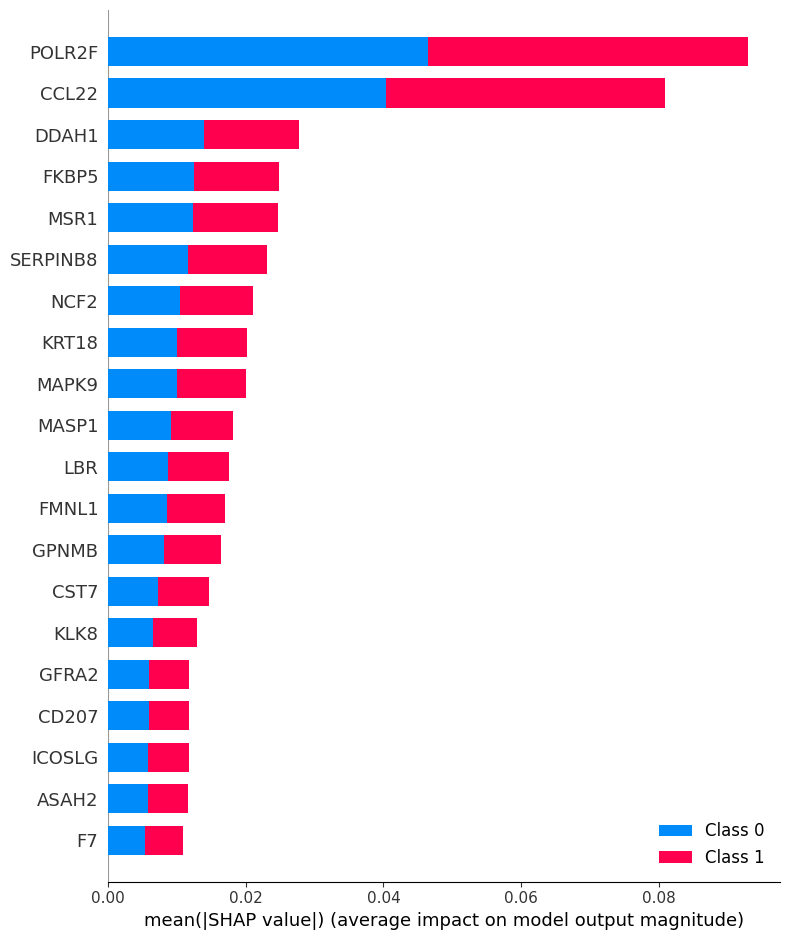

In [33]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test1,feature_names=X.columns, max_display =20,show=False )
plt.savefig('xai_mgh_mya.svg')

In [29]:
fig = px.area(
    x=fpr1, y=tpr1,
    title=f'ROC Curve (AUC={auc(fpr1, tpr1):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
# fig.write_image("fig1.svg")
# fig.show()
plotly.offline.plot(fig, filename='ppp', image='svg')

/usr/local/lib/python3.10/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `ppp` didn't end with .html. Adding .html to the end of your file.



'ppp.html'

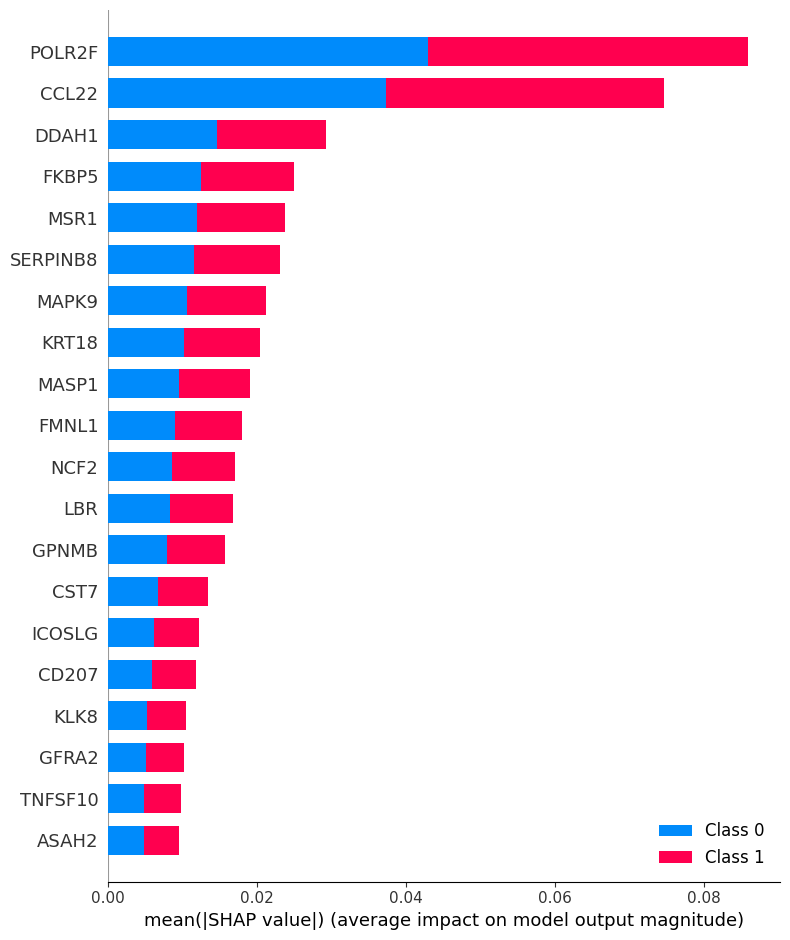

In [34]:
shap_values2 = explainer.shap_values(X_test2)
shap.summary_plot(shap_values2,X_test2,feature_names=X.columns, max_display =20,show=False )
plt.savefig('xai_mgh_std.svg')

In [32]:
fig = px.area(
    x=fpr2, y=tpr2,
    title=f'ROC Curve (AUC={auc(fpr2, tpr2):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
# fig.write_image("fig1.svg")
# fig.show()
plotly.offline.plot(fig, filename='ppp', image='svg')

/usr/local/lib/python3.10/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `ppp` didn't end with .html. Adding .html to the end of your file.



'ppp.html'